In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [4]:
accidents = pd.read_csv("./accidents.csv")
autos = pd.read_csv("./autos.csv")
concrete = pd.read_csv("./concrete.csv")
customer = pd.read_csv("./customer.csv")

In [5]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


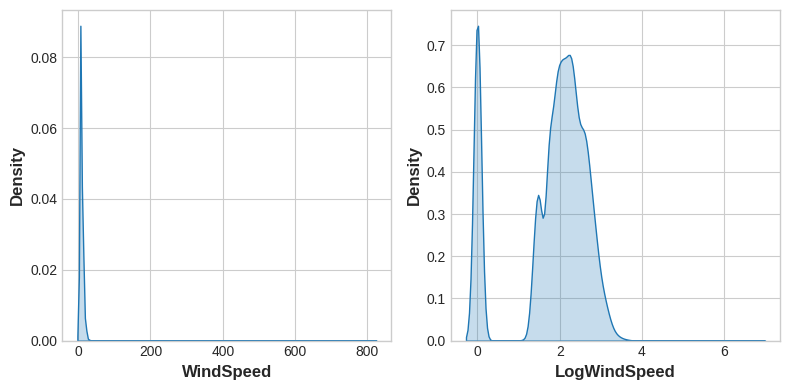

In [6]:
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=axs[1]);

In [7]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

In [8]:
accidents[roadway_features + ['RoadwayFeatures']].head()

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0


In [9]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water", "Superplasticizer", "CoarseAggregate", "FineAggregate"]

In [10]:
concrete['Components'] = concrete[components].gt(0).sum(axis=1)

In [11]:
concrete[['Components'] + components].head() 

,Components,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate
0,5,540.0,0.0,0.0,162.0,2.5,1040.0,676.0
1,5,540.0,0.0,0.0,162.0,2.5,1055.0,676.0
2,5,332.5,142.5,0.0,228.0,0.0,932.0,594.0
3,5,332.5,142.5,0.0,228.0,0.0,932.0,594.0
4,5,198.6,132.4,0.0,192.0,0.0,978.4,825.5


In [12]:
customer[['Type', 'Level']] = customer['Policy'].str.split(" ", expand=True)

In [13]:
customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


In [14]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


In [15]:
customer["AverageIncome"] = customer.groupby('State')['Income'].transform('mean')

In [16]:
customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


In [17]:
customer["StateFreq"] = customer.groupby("State")["State"].transform("count") / customer.State.count()

In [18]:
customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [19]:
df_train = customer.sample(frac = 0.5)
df_valid = customer.drop(df_train.index)

df_train['AverageClaim'] = df_train.groupby('Coverage')['ClaimAmount'].transform('mean')

In [20]:
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

In [21]:
df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,382.335985
1,Extended,487.493279
2,Basic,382.335985
3,Basic,382.335985
4,Basic,382.335985
5,Extended,487.493279
6,Basic,382.335985
7,Basic,382.335985
8,Basic,382.335985
9,Basic,382.335985


In [22]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

In [23]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
    
    score = cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_log_error',
    )
    score = -score.mean()
    score = np.sqrt(score)
    return score

In [24]:
df = pd.read_csv('./ames.csv')
X = df.copy()
y = X.pop('SalePrice')

In [25]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,5,2010,WD,Normal
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,120.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2010,WD,Normal
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,0.0,No_Pool,No_Fence,None,0.0,4,2010,WD,Normal
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,3,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,0.0,0.0,No_Pool,Good_Privacy,None,0.0,3,2006,WD,Normal
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885.0,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,None,0.0,6,2006,WD,Normal
2927,Split_Foyer,Residential_Low_Density,62.0,10441.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,Minimum_Privacy,Shed,700.0,7,2006,WD,Normal
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,0.0,No_Pool,No_Fence,None,0.0,4,2006,WD,Normal


In [26]:
X_1 = pd.DataFrame()  

X_1["LivLotRatio"] = X.GrLivArea / X.LotArea
X_1["Spaciousness"] = (X.FirstFlrSF + X.SecondFlrSF) / X.TotRmsAbvGrd
X_1["TotalOutsideSF"] = X.WoodDeckSF + X.OpenPorchSF + X.EnclosedPorch + X.Threeseasonporch + X.ScreenPorch

In [28]:
X_2 = pd.get_dummies(df.BldgType, prefix='Bldg')
# Multiply
X_2 = X_2.mul(df.GrLivArea, axis=0)


In [33]:
X_3 = pd.DataFrame()

X_3['PorchTypes'] = df[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch']].gt(0).sum(axis=1)
X_3

,PorchTypes
0,2
1,2
2,2
3,0
4,2
...,...
2925,1
2926,1
2927,2
2928,2


In [74]:
X_4 = pd.DataFrame()
X_4["MSClass"] = df.MSSubClass.str.split("_", expand=True)[0] 

In [75]:
X_5 = pd.DataFrame()


X_5["MedNhbdArea"] = df.groupby('Neighborhood')['GrLivArea'].transform('median')

In [76]:
X_new = X.join([X_1, X_2, X_3, X_4, X_5])
score_dataset(X_new, y)

0.13865658070461215